# GTSRB classification with CNN - Dataset analysis and preparation

Inspired by the [GTSRB Fidle tutorial](https://fidle.cnrs.fr/w3/)

## 1. Imports

In [88]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import skimage
import time as time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from skimage import color, io, transform, exposure
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage.morphology import disk
from torch.utils.data import DataLoader

## 2. Parameters

In [75]:
scale = 0.2
rng = np.random.default_rng(int(time.time()))
input_dir = 'data'
output_dir = 'prepared_data'

## 3. Read the dataset

In [76]:
def read_csv_dataset(csv_file, rng, scale=1.0):
	# Read CSV file
	df = pd.read_csv(csv_file, header=0)

	# Get filenames and labels
	path = os.path.dirname(csv_file)
	filenames = df['Path'].to_list()
	labels = df['ClassId'].to_list()

	# Shuffle and reduce dataset
	combined = list(zip(filenames, labels))
	rng.shuffle(combined)
	reduced_size = int(scale * len(combined))
	combined = combined[:reduced_size]
	filenames, labels = zip(*combined)

	# Load images
	images = [io.imread(f'{path}/{filename}') for filename in filenames]

	return np.array(images, dtype=object), np.array(labels)

In [77]:
# Read datasets
x_train, y_train = read_csv_dataset(f'{input_dir}/Train.csv', rng, scale)
x_test,  y_test  = read_csv_dataset(f'{input_dir}/Test.csv',  rng)
x_meta,  y_meta  = read_csv_dataset(f'{input_dir}/Meta.csv',  rng)

# Sort Meta
combined = list(zip(x_meta,y_meta))
combined.sort(key=lambda x: x[1])
x_meta,y_meta = zip(*combined)

## 4. Few statistics about train dataset

In [78]:
train_size  = []
train_ratio = []
train_lx    = []
train_ly    = []

test_size   = []
test_ratio  = []
test_lx     = []
test_ly     = []

for image in x_train:
    (lx,ly,lz) = image.shape
    train_size.append(lx*ly/1024)
    train_ratio.append(lx/ly)
    train_lx.append(lx)
    train_ly.append(ly)

for image in x_test:
    (lx,ly,lz) = image.shape
    test_size.append(lx*ly/1024)
    test_ratio.append(lx/ly)
    test_lx.append(lx)
    test_ly.append(ly)

Number of images in train :  7841
Number of images in test  :  12630


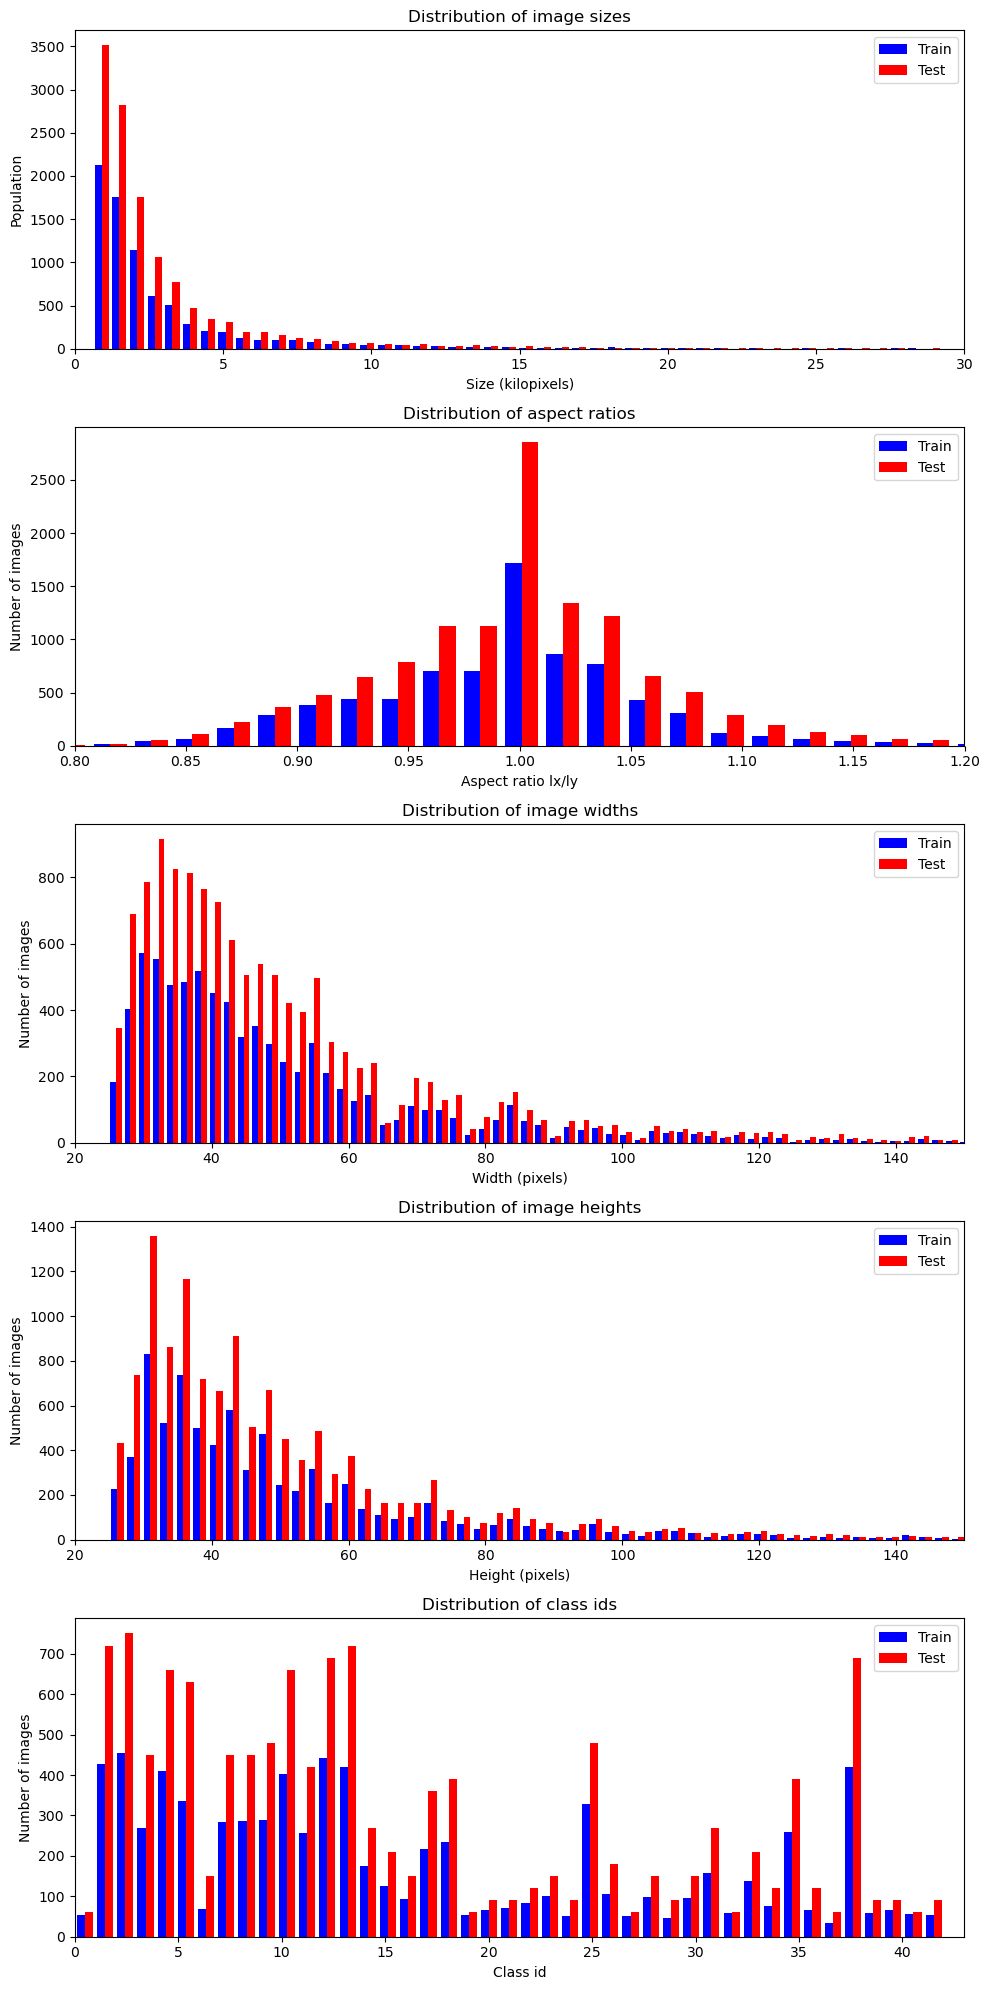

In [79]:
# Global
print("Number of images in train : ", len(x_train))
print("Number of images in test  : ", len(x_test))

fig, axs = plt.subplots(5, 1, figsize=(10, 20))

# Sizes
axs[0].hist([train_size, test_size], bins=100, color=['blue', 'red'])
axs[0].set(
	title='Distribution of image sizes',
	xlabel='Size (kilopixels)',
	ylabel='Population',
	xlim=[0, 30]
)
axs[0].legend(['Train', 'Test'])

# Ratio lx/ly
axs[1].hist([train_ratio,test_ratio], bins=100, color=['blue', 'red'])
axs[1].set(
	title='Distribution of aspect ratios',
	xlabel='Aspect ratio lx/ly',
	ylabel='Number of images',
	xlim=[0.8, 1.2]
)
axs[1].legend(['Train', 'Test'])

# lx
axs[2].hist([train_lx,test_lx], bins=100, color=['blue', 'red'])
axs[2].set(
	title='Distribution of image widths',
	xlabel='Width (pixels)',
	ylabel='Number of images',
	xlim=[20, 150]
)
axs[2].legend(['Train', 'Test'])

# ly
axs[3].hist([train_ly,test_ly], bins=100, color=['blue', 'red'])
axs[3].set(
	title='Distribution of image heights',
	xlabel='Height (pixels)',
	ylabel='Number of images',
	xlim=[20, 150]
)
axs[3].legend(['Train', 'Test'])

# Statistics / classId
axs[4].hist([y_train,y_test], bins=43, color=['blue', 'red'])
axs[4].set(
	title='Distribution of class ids',
	xlabel='Class id',
	ylabel='Number of images',
	xlim=[0, 43]
)
axs[4].legend(['Train', 'Test'])

plt.tight_layout()
plt.show()

## 5. Comparaison of theoretical and real images

In [80]:
def plot_imgs(images, labels, num_imgs):
	cols = 8
	rows = (num_imgs + cols - 1) // cols

	fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
	fig.subplots_adjust(hspace=0.5, wspace=0.5)

	# Show the images
	for i in range(num_imgs):
		ax = axes[i // cols, i % cols]
		ax.imshow(images[i])
		ax.set_xlabel(labels[i])
		ax.set_xticks([])
		ax.set_yticks([])

	# Fill the empty plots with white images
	for j in range(len(y_meta), rows * cols):
		ax = axes[j // cols, j % cols]
		ax.axis('off')

	plt.show()

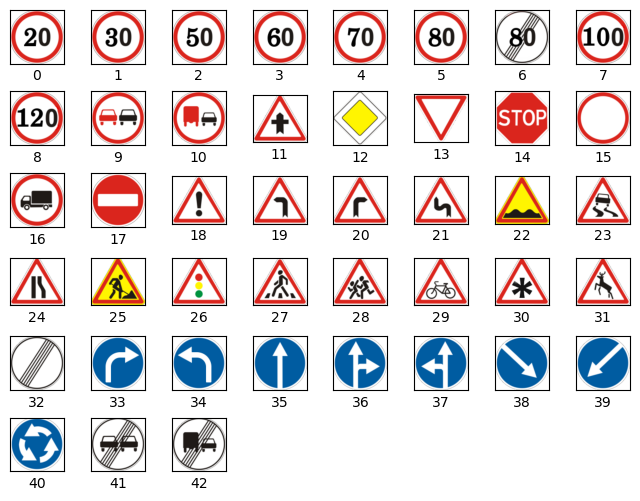

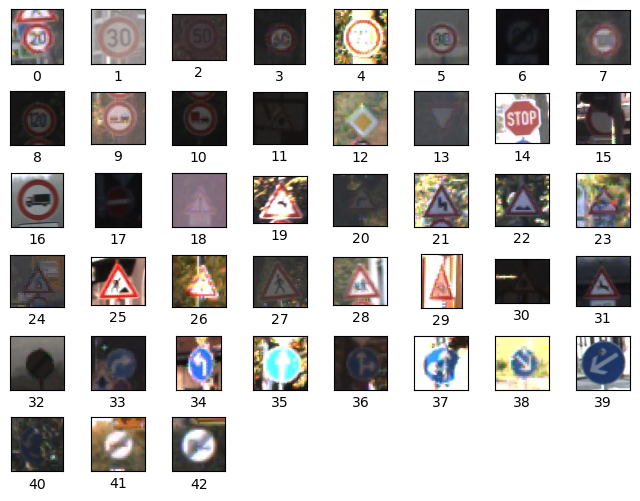

In [81]:
# Print theoretical images
plot_imgs(x_meta, y_meta, 43)

# Print real images
images = [io.imread(f'data/Train/{i}/{i:05d}_00000_00000.png') for i in range(43)]
plot_imgs(images, list(range(43)), 43)

## Step 7 - dataset cooking...

Images **must** :
 - have the **same size** to match the size of the network,
 - be **normalized**.  
 
It is possible to work on **rgb** or **monochrome** images and to **equalize** the histograms.   

See : [Exposure with scikit-image](https://scikit-image.org/docs/dev/api/skimage.exposure.html)  
See : [Local histogram equalization](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.equalize)  
See : [Histogram equalization](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist)  

### 7.1 - Enhancement cooking
A nice function for preparing our data.  
Input: a set of images (numpy array)  
Output: a enhanced images, resized and reprocessed (numpy array)

In [82]:
def images_enhancement(images, width=25, height=25, proc='RGB'):
	'''
	Resize and convert images - doesn't change originals.
	input images must be RGBA or RGB.
	Note : all outputs are fixed size numpy array of float32
	args:
		images :         images list
		width,height :   new images size (25,25)
		mode :           RGB | RGB-HE | L | L-HE | L-LHE | L-CLAHE
	return:
		numpy array of enhanced images
	'''
	lz = {'RGB':3, 'RGB-HE':3, 'L':1, 'L-HE':1, 'L-LHE':1, 'L-CLAHE':1}[proc]
	
	out = []
	for img in images:
		
		# ---- if RGBA, convert to RGB
		if img.shape[2] == 4:
			img = color.rgba2rgb(img)
			
		# ---- Resize
		img = transform.resize(img, (width,height))

		# ---- RGB / Histogram Equalization
		if proc=='RGB-HE':
			hsv = color.rgb2hsv(img.reshape(width,height,3))
			hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
			img = color.hsv2rgb(hsv)
		
		# ---- Grayscale
		if proc=='L':
			img=color.rgb2gray(img)
			
		# ---- Grayscale / Histogram Equalization
		if proc=='L-HE':
			img=color.rgb2gray(img)
			img=exposure.equalize_hist(img)
			
		# ---- Grayscale / Local Histogram Equalization
		if proc=='L-LHE':        
			img=color.rgb2gray(img)
			img = img_as_ubyte(img)
			img=rank.equalize(img, disk(10))/255.
		
		# ---- Grayscale / Contrast Limited Adaptive Histogram Equalization (CLAHE)
		if proc=='L-CLAHE':
			img=color.rgb2gray(img)
			img=exposure.equalize_adapthist(img)
			
		# ---- Add image in list of list
		out.append(img)

	# ---- Reshape images
	#     (-1, width,height,1) for L
	#     (-1, width,height,3) for RGB
	#
	out = np.array(out,dtype='float32')
	out = out.reshape(-1,width,height,lz)
	return out

### 7.2 - To get an idea of the different recipes

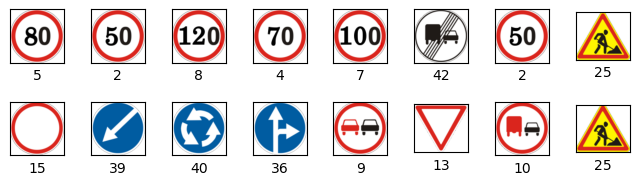

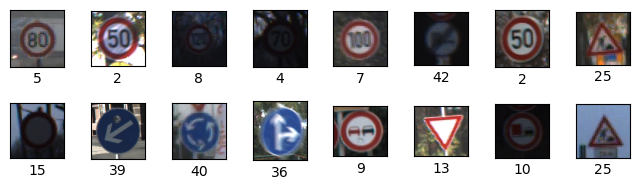

dataset : RGB  min,max=[0.019,1.000]  shape=(16, 25, 25, 3)


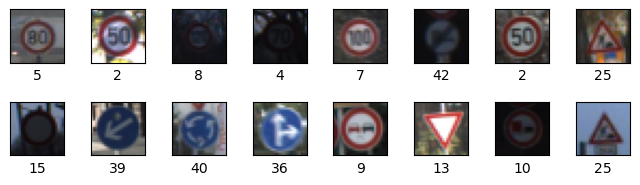

dataset : RGB-HE  min,max=[0.001,1.000]  shape=(16, 25, 25, 3)


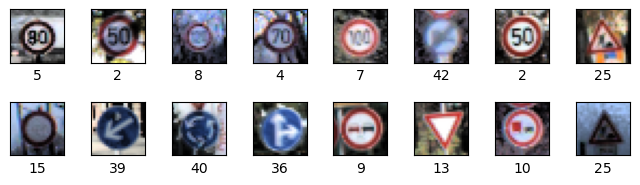

dataset : L  min,max=[0.032,1.000]  shape=(16, 25, 25, 1)


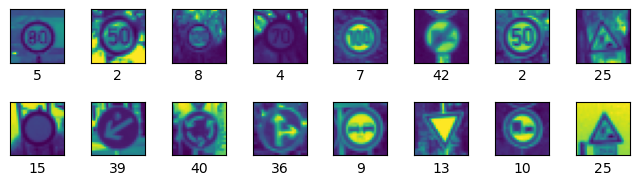

dataset : L-HE  min,max=[0.002,1.000]  shape=(16, 25, 25, 1)


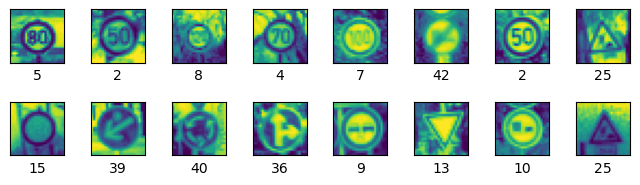

dataset : L-LHE  min,max=[0.000,1.000]  shape=(16, 25, 25, 1)


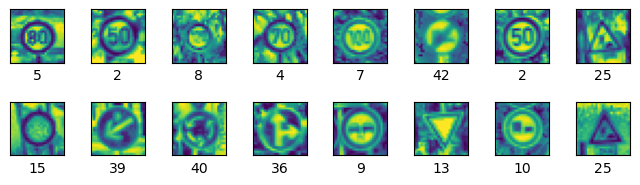

dataset : L-CLAHE  min,max=[0.000,1.000]  shape=(16, 25, 25, 1)


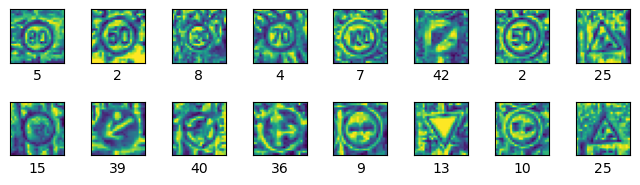

In [83]:
i = rng.integers(0, len(x_train)-16)
x_samples = x_train[i:i+16]
y_samples = y_train[i:i+16]

datasets  = {}

datasets['RGB']      = images_enhancement( x_samples, width=25, height=25, proc='RGB'  )
datasets['RGB-HE']   = images_enhancement( x_samples, width=25, height=25, proc='RGB-HE'  )
datasets['L']        = images_enhancement( x_samples, width=25, height=25, proc='L'  )
datasets['L-HE']     = images_enhancement( x_samples, width=25, height=25, proc='L-HE'  )
datasets['L-LHE']    = images_enhancement( x_samples, width=25, height=25, proc='L-LHE'  )
datasets['L-CLAHE']  = images_enhancement( x_samples, width=25, height=25, proc='L-CLAHE'  )

# fidle.utils.subtitle('EXPECTED')
x_expected=[ x_meta[i] for i in y_samples]
plot_imgs(x_expected, y_samples, 16)
# fidle.scrawler.images(x_expected, y_samples, range(12), columns=12, x_size=1, y_size=1,
                # colorbar=False, y_pred=None, cm='binary', save_as='08-expected')

# fidle.utils.subtitle('ORIGINAL')
# fidle.scrawler.images(x_samples,  y_samples, range(12), columns=12, x_size=1, y_size=1, 
#                 colorbar=False, y_pred=None, cm='binary', save_as='09-original')
plot_imgs(x_samples, y_samples, 16)

# fidle.utils.subtitle('ENHANCED')
n=10
for k,d in datasets.items():
    print("dataset : {}  min,max=[{:.3f},{:.3f}]  shape={}".format(k,d.min(),d.max(), d.shape))
    # fidle.scrawler.images(d, y_samples, range(12), columns=12, x_size=1, y_size=1, 
    #                 colorbar=False, y_pred=None, cm='binary', save_as=f'{n}-enhanced-{k}')
    plot_imgs(d, y_samples, 16)
    n+=1


### 7.3 - Cook and save

A function to save a dataset (h5 file)

In [84]:
def save_h5_dataset(x_train, y_train, x_test, y_test, x_meta,y_meta, filename):
        
    # ---- Create h5 file
    with h5py.File(filename, "w") as f:
        f.create_dataset("x_train", data=x_train)
        f.create_dataset("y_train", data=y_train)
        f.create_dataset("x_test",  data=x_test)
        f.create_dataset("y_test",  data=y_test)
        f.create_dataset("x_meta",  data=x_meta)
        f.create_dataset("y_meta",  data=y_meta)
        
    # ---- done
    size=os.path.getsize(filename)/(1024*1024)
    print('Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)'.format(filename, str(x_train.shape),size))

Generate enhanced datasets :

In [89]:
# ---- Size and processings
#
all_size= [24, 48]
all_proc=['RGB', 'RGB-HE', 'L', 'L-LHE']

# ---- Do it
#
# chrono.start()

n_train = int( len(x_train)*scale )
n_test  = int( len(x_test)*scale )

# fidle.utils.subtitle('Parameters :')
print(f'Scale is : {scale}')
print(f'x_train length is : {n_train}')
print(f'x_test  length is : {n_test}')
print(f'output dir is     : {output_dir}\n')

# fidle.utils.subtitle('Running...')

# fidle.utils.mkdir(output_dir)
os.makedirs(output_dir, exist_ok=True)

for s in all_size:
    for m in all_proc:
        # ---- A nice dataset name
        filename = f'{output_dir}/set-{s}x{s}-{m}.h5'
        # fidle.utils.subtitle(f'Dataset : {filename}')
        
        # ---- Enhancement
        #      Note : x_train is a numpy array of python objects (images with <> sizes)
        #             but images_enhancement() return a real array of float64 numpy (images with same size)
        #             so, we can save it in nice h5 files
        #
        x_train_new = images_enhancement( x_train[:n_train], width=s, height=s, proc=m )
        x_test_new  = images_enhancement( x_test[:n_test],   width=s, height=s, proc=m )
        x_meta_new  = images_enhancement( x_meta,            width=s, height=s, proc='RGB' )
        
        # ---- Save
        save_h5_dataset( x_train_new, y_train[:n_train], x_test_new, y_test[:n_test], x_meta_new,y_meta, filename)

x_train_new,x_test_new=0,0

print('\nDone.')
# chrono.show()

Scale is : 0.2
x_train length is : 1568
x_test  length is : 2526
output dir is     : prepared_data

Dataset : prepared_data/set-24x24-RGB.h5  shape : (1568, 24, 24, 3)      size :   27.3 Mo   (saved)
Dataset : prepared_data/set-24x24-RGB-HE.h5  shape : (1568, 24, 24, 3)      size :   27.3 Mo   (saved)
Dataset : prepared_data/set-24x24-L.h5  shape : (1568, 24, 24, 1)      size :    9.3 Mo   (saved)
Dataset : prepared_data/set-24x24-L-LHE.h5  shape : (1568, 24, 24, 1)      size :    9.3 Mo   (saved)
Dataset : prepared_data/set-48x48-RGB.h5  shape : (1568, 48, 48, 3)      size :  109.1 Mo   (saved)
Dataset : prepared_data/set-48x48-RGB-HE.h5  shape : (1568, 48, 48, 3)      size :  109.1 Mo   (saved)
Dataset : prepared_data/set-48x48-L.h5  shape : (1568, 48, 48, 1)      size :   37.2 Mo   (saved)
Dataset : prepared_data/set-48x48-L-LHE.h5  shape : (1568, 48, 48, 1)      size :   37.2 Mo   (saved)

Done.


## Step 8 - Reload data to be sure ;-)

dataset loaded from h5 file.


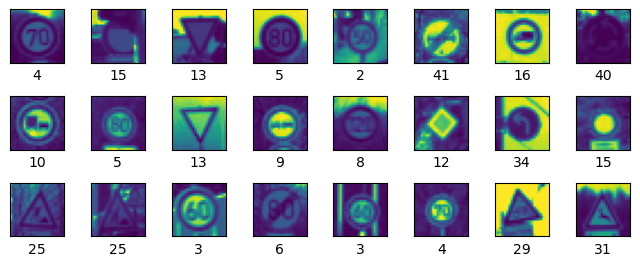

In [90]:
# chrono.start()

dataset='set-24x24-L'
samples=range(24)

with  h5py.File(f'{output_dir}/{dataset}.h5','r') as f:
    x_tmp = f['x_train'][:]
    y_tmp = f['y_train'][:]
    print("dataset loaded from h5 file.")

# fidle.scrawler.images(x_tmp,y_tmp, samples, columns=8, x_size=1.5, y_size=1.5, 
#                 colorbar=False, y_pred=None, cm='binary', save_as='16-enhanced_images')
plot_imgs(x_tmp, y_tmp, 24)
x_tmp,y_tmp=0,0

# chrono.show()